<h1>Model: Female Anger vs. Others</h1>

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'ANG':
        return 1
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'ANG'
    else:
        return 'OTH'
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getEmotion(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getEmotion(k),v) for k,v in Counter(Y_train_labelled).items()])

    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=2)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    return(X_train,Y_train)

In [4]:
X_all = []
Y_all = []

image_folder_path = '../cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    split_file_name = file_name.split('_')
    if split_file_name[0] == 'F':
        spectrogram = Image.open(image_folder_path + '/' + file_name)
        spectrogram = spectrogram.convert('L')
        spectrogram = spectrogram.resize((167, 109))
        spectrogram = np.array(spectrogram)
        spectrogram = np.expand_dims(spectrogram, axis=2)
        X_all.append(spectrogram)
        Y_all.append(getEmotionCode(file_name))
    


In [5]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)



X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2)

print(X_all.shape)
print(Y_all.shape)



(3515, 109, 167, 1)
(3515, 2)


In [6]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)



<h2>Keras Tuner</h2>

In [7]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Int('conv1',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv1size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=7),
                           strides=(2,2),padding='same')(inp)
        
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)

        #conv2
        c2 = Convolution2D(filters=hp.Int('conv2',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv2size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=5),
                           strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)
        
        #conv3
        c2 = Convolution2D(filters=hp.Int('conv3',
                                 min_value=64,
                                 max_value=256,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv3size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(2,2),padding='same')(mpool)
        
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        #Conv 4
        c3 = Convolution2D(filters=hp.Int('conv4',
                                 min_value=64,
                                 max_value=512,
                                 step=16,
                                 default=64),
                           kernel_size=hp.Int('conv4size',
                                 min_value=3,
                                 max_value=7,
                                 step=2,
                                 default=3),
                           strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(256)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(64)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(2, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [8]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(109,167,1), num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='fem_and_others_4_oct'
)

In [9]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Epoch 1/70
317/317 - 10s - loss: 0.4038 - accuracy: 0.8130 - val_loss: 0.4915 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 2s - loss: 0.3557 - accuracy: 0.8375 - val_loss: 0.3406 - val_accuracy: 0.8227
Epoch 3/70
317/317 - 2s - loss: 0.3356 - accuracy: 0.8403 - val_loss: 0.7447 - val_accuracy: 0.6312
Epoch 4/70
317/317 - 2s - loss: 0.3283 - accuracy: 0.8403 - val_loss: 0.2994 - val_accuracy: 0.8511
Epoch 5/70
317/317 - 2s - loss: 0.3300 - accuracy: 0.8368 - val_loss: 0.2934 - val_accuracy: 0.8688
Epoch 6/70
317/317 - 2s - loss: 0.3200 - accuracy: 0.8415 - val_loss: 0.2401 - val_accuracy: 0.8794
Epoch 7/70
317/317 - 2s - loss: 0.3017 - accuracy: 0.8680 - val_loss: 0.3579 - val_accuracy: 0.7979
Epoch 8/70
317/317 - 2s - loss: 0.2995 - accuracy: 0.8561 - val_loss: 0.3105 - val_accuracy: 0.8227
Epoch 9/70
317/317 - 2s - loss: 0.2964 - accuracy: 0.8593 - val_loss: 0.2512 - val_accuracy: 0.8830
Epoch 10/70
317/317 - 2s - loss: 0.2879 - accuracy: 0.8644 - val_loss: 0.2393 - val_accuracy: 0.893

Epoch 13/70
317/317 - 3s - loss: 0.2797 - accuracy: 0.8767 - val_loss: 0.2748 - val_accuracy: 0.8440
Epoch 14/70
317/317 - 3s - loss: 0.2770 - accuracy: 0.8779 - val_loss: 0.3210 - val_accuracy: 0.8794
Epoch 15/70
317/317 - 2s - loss: 0.2572 - accuracy: 0.8834 - val_loss: 0.2651 - val_accuracy: 0.9113
Epoch 16/70
317/317 - 2s - loss: 0.2615 - accuracy: 0.8901 - val_loss: 0.2487 - val_accuracy: 0.8865
Epoch 17/70
317/317 - 2s - loss: 0.2538 - accuracy: 0.8877 - val_loss: 0.2739 - val_accuracy: 0.8652
Epoch 18/70
317/317 - 2s - loss: 0.2555 - accuracy: 0.8893 - val_loss: 0.2762 - val_accuracy: 0.8652
Epoch 19/70
317/317 - 2s - loss: 0.2488 - accuracy: 0.8850 - val_loss: 0.2747 - val_accuracy: 0.8794
Epoch 20/70
317/317 - 2s - loss: 0.2587 - accuracy: 0.8929 - val_loss: 0.2685 - val_accuracy: 0.8582
Epoch 21/70
317/317 - 2s - loss: 0.2362 - accuracy: 0.9024 - val_loss: 0.2523 - val_accuracy: 0.9043
Epoch 22/70
317/317 - 2s - loss: 0.2362 - accuracy: 0.8976 - val_loss: 0.2458 - val_accurac

Epoch 1/70
317/317 - 10s - loss: 0.4426 - accuracy: 0.7917 - val_loss: 0.8555 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 3s - loss: 0.3846 - accuracy: 0.8257 - val_loss: 0.3660 - val_accuracy: 0.8830
Epoch 3/70
317/317 - 3s - loss: 0.3389 - accuracy: 0.8403 - val_loss: 0.4717 - val_accuracy: 0.7553
Epoch 4/70
317/317 - 3s - loss: 0.3396 - accuracy: 0.8360 - val_loss: 0.2783 - val_accuracy: 0.8794
Epoch 5/70
317/317 - 3s - loss: 0.3226 - accuracy: 0.8498 - val_loss: 0.3544 - val_accuracy: 0.8227
Epoch 6/70
317/317 - 3s - loss: 0.3181 - accuracy: 0.8387 - val_loss: 0.4064 - val_accuracy: 0.8723
Epoch 7/70
317/317 - 3s - loss: 0.3027 - accuracy: 0.8625 - val_loss: 0.2475 - val_accuracy: 0.8794
Epoch 8/70
317/317 - 3s - loss: 0.2930 - accuracy: 0.8680 - val_loss: 0.7393 - val_accuracy: 0.8652
Epoch 9/70
317/317 - 3s - loss: 0.2989 - accuracy: 0.8723 - val_loss: 0.3028 - val_accuracy: 0.8191
Epoch 10/70
317/317 - 3s - loss: 0.2912 - accuracy: 0.8664 - val_loss: 0.5168 - val_accuracy: 0.865

Epoch 13/70
317/317 - 3s - loss: 0.2810 - accuracy: 0.8798 - val_loss: 0.6663 - val_accuracy: 0.6028
Epoch 14/70
317/317 - 3s - loss: 0.2746 - accuracy: 0.8763 - val_loss: 0.2530 - val_accuracy: 0.9043
Epoch 15/70
317/317 - 3s - loss: 0.2573 - accuracy: 0.8909 - val_loss: 0.3208 - val_accuracy: 0.8794
Epoch 16/70
317/317 - 3s - loss: 0.2660 - accuracy: 0.8787 - val_loss: 0.2372 - val_accuracy: 0.9078
Epoch 17/70
317/317 - 3s - loss: 0.2544 - accuracy: 0.8905 - val_loss: 0.2397 - val_accuracy: 0.8972
Epoch 18/70
317/317 - 3s - loss: 0.2417 - accuracy: 0.8921 - val_loss: 0.2397 - val_accuracy: 0.9007
Epoch 19/70
317/317 - 3s - loss: 0.2437 - accuracy: 0.8937 - val_loss: 0.2987 - val_accuracy: 0.8865
Epoch 20/70
317/317 - 3s - loss: 0.2285 - accuracy: 0.9012 - val_loss: 0.2376 - val_accuracy: 0.8865
Epoch 21/70
317/317 - 3s - loss: 0.2299 - accuracy: 0.8992 - val_loss: 0.2302 - val_accuracy: 0.9043
Epoch 22/70
317/317 - 3s - loss: 0.2380 - accuracy: 0.9036 - val_loss: 0.2855 - val_accurac

Epoch 1/70
317/317 - 11s - loss: 0.4611 - accuracy: 0.7783 - val_loss: 1.0032 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 4s - loss: 0.3539 - accuracy: 0.8249 - val_loss: 0.2959 - val_accuracy: 0.8688
Epoch 3/70
317/317 - 4s - loss: 0.3362 - accuracy: 0.8316 - val_loss: 0.2808 - val_accuracy: 0.8546
Epoch 4/70
317/317 - 4s - loss: 0.3313 - accuracy: 0.8447 - val_loss: 0.2377 - val_accuracy: 0.8865
Epoch 5/70
317/317 - 4s - loss: 0.3165 - accuracy: 0.8538 - val_loss: 0.6401 - val_accuracy: 0.8652
Epoch 6/70
317/317 - 4s - loss: 0.3832 - accuracy: 0.8253 - val_loss: 0.3214 - val_accuracy: 0.8723
Epoch 7/70
317/317 - 4s - loss: 0.3266 - accuracy: 0.8545 - val_loss: 0.2583 - val_accuracy: 0.8652
Epoch 8/70
317/317 - 4s - loss: 0.3171 - accuracy: 0.8569 - val_loss: 0.3042 - val_accuracy: 0.8582
Epoch 9/70
317/317 - 4s - loss: 0.3073 - accuracy: 0.8593 - val_loss: 0.2832 - val_accuracy: 0.8475
Epoch 10/70
317/317 - 4s - loss: 0.3046 - accuracy: 0.8617 - val_loss: 0.2541 - val_accuracy: 0.879

Epoch 13/70
317/317 - 4s - loss: 0.2615 - accuracy: 0.8818 - val_loss: 0.2795 - val_accuracy: 0.8936
Epoch 14/70
317/317 - 4s - loss: 0.2552 - accuracy: 0.8921 - val_loss: 0.2842 - val_accuracy: 0.8617
Epoch 15/70
317/317 - 4s - loss: 0.2507 - accuracy: 0.8968 - val_loss: 0.2260 - val_accuracy: 0.9007
Epoch 16/70
317/317 - 4s - loss: 0.2336 - accuracy: 0.9028 - val_loss: 0.2245 - val_accuracy: 0.8972
Epoch 17/70
317/317 - 4s - loss: 0.2304 - accuracy: 0.9043 - val_loss: 0.3529 - val_accuracy: 0.8830
Epoch 18/70
317/317 - 4s - loss: 0.2321 - accuracy: 0.8988 - val_loss: 0.6517 - val_accuracy: 0.8652
Epoch 19/70
317/317 - 4s - loss: 0.2268 - accuracy: 0.9087 - val_loss: 0.2290 - val_accuracy: 0.8936
Epoch 20/70
317/317 - 4s - loss: 0.2212 - accuracy: 0.9071 - val_loss: 0.2815 - val_accuracy: 0.8936
Epoch 21/70
317/317 - 4s - loss: 0.2386 - accuracy: 0.8988 - val_loss: 0.4203 - val_accuracy: 0.8014
Epoch 22/70
317/317 - 4s - loss: 0.2028 - accuracy: 0.9225 - val_loss: 0.2533 - val_accurac

Epoch 1/70
317/317 - 9s - loss: 0.4444 - accuracy: 0.7881 - val_loss: 0.4247 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 2s - loss: 0.3656 - accuracy: 0.8249 - val_loss: 0.3194 - val_accuracy: 0.8652
Epoch 3/70
317/317 - 2s - loss: 0.3477 - accuracy: 0.8320 - val_loss: 0.3624 - val_accuracy: 0.8652
Epoch 4/70
317/317 - 2s - loss: 0.3301 - accuracy: 0.8443 - val_loss: 0.2966 - val_accuracy: 0.8227
Epoch 5/70
317/317 - 2s - loss: 0.3242 - accuracy: 0.8411 - val_loss: 0.3859 - val_accuracy: 0.7837
Epoch 6/70
317/317 - 2s - loss: 0.3062 - accuracy: 0.8565 - val_loss: 0.2765 - val_accuracy: 0.8759
Epoch 7/70
317/317 - 2s - loss: 0.3165 - accuracy: 0.8490 - val_loss: 0.2745 - val_accuracy: 0.9078
Epoch 8/70
317/317 - 2s - loss: 0.2977 - accuracy: 0.8648 - val_loss: 0.2600 - val_accuracy: 0.8759
Epoch 9/70
317/317 - 2s - loss: 0.2942 - accuracy: 0.8601 - val_loss: 0.4490 - val_accuracy: 0.7482
Epoch 10/70
317/317 - 2s - loss: 0.3020 - accuracy: 0.8696 - val_loss: 0.2672 - val_accuracy: 0.8830

Epoch 13/70
317/317 - 2s - loss: 0.2952 - accuracy: 0.8632 - val_loss: 0.2980 - val_accuracy: 0.8511
Epoch 14/70
317/317 - 3s - loss: 0.2802 - accuracy: 0.8723 - val_loss: 0.2665 - val_accuracy: 0.8652
Epoch 15/70
317/317 - 2s - loss: 0.2850 - accuracy: 0.8676 - val_loss: 0.4266 - val_accuracy: 0.8688
Epoch 16/70
317/317 - 2s - loss: 0.2773 - accuracy: 0.8688 - val_loss: 0.3098 - val_accuracy: 0.8901
Epoch 17/70
317/317 - 2s - loss: 0.2728 - accuracy: 0.8822 - val_loss: 0.6659 - val_accuracy: 0.8652
Epoch 18/70
317/317 - 2s - loss: 0.2734 - accuracy: 0.8759 - val_loss: 0.2310 - val_accuracy: 0.8972
Epoch 19/70
317/317 - 2s - loss: 0.2729 - accuracy: 0.8759 - val_loss: 0.2680 - val_accuracy: 0.8688
Epoch 20/70
317/317 - 2s - loss: 0.2711 - accuracy: 0.8818 - val_loss: 0.2990 - val_accuracy: 0.9043
Epoch 21/70
317/317 - 3s - loss: 0.2569 - accuracy: 0.8897 - val_loss: 0.2489 - val_accuracy: 0.9007
Epoch 22/70
317/317 - 2s - loss: 0.2536 - accuracy: 0.8909 - val_loss: 0.2560 - val_accurac

Epoch 1/70
317/317 - 10s - loss: 0.4289 - accuracy: 0.8043 - val_loss: 0.8486 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 3s - loss: 0.3705 - accuracy: 0.8261 - val_loss: 0.3525 - val_accuracy: 0.8369
Epoch 3/70
317/317 - 3s - loss: 0.3290 - accuracy: 0.8490 - val_loss: 0.2975 - val_accuracy: 0.8475
Epoch 4/70
317/317 - 3s - loss: 0.3243 - accuracy: 0.8411 - val_loss: 0.5417 - val_accuracy: 0.6667
Epoch 5/70
317/317 - 3s - loss: 0.3109 - accuracy: 0.8462 - val_loss: 0.2765 - val_accuracy: 0.8688
Epoch 6/70
317/317 - 3s - loss: 0.3041 - accuracy: 0.8577 - val_loss: 0.2518 - val_accuracy: 0.8759
Epoch 7/70
317/317 - 3s - loss: 0.3005 - accuracy: 0.8621 - val_loss: 0.3267 - val_accuracy: 0.8901
Epoch 8/70
317/317 - 3s - loss: 0.2940 - accuracy: 0.8636 - val_loss: 0.3341 - val_accuracy: 0.8227
Epoch 9/70
317/317 - 3s - loss: 0.2895 - accuracy: 0.8711 - val_loss: 0.3141 - val_accuracy: 0.8227
Epoch 10/70
317/317 - 3s - loss: 0.3030 - accuracy: 0.8680 - val_loss: 0.2395 - val_accuracy: 0.897

Epoch 13/70
317/317 - 3s - loss: 0.2767 - accuracy: 0.8751 - val_loss: 0.2508 - val_accuracy: 0.8794
Epoch 14/70
317/317 - 3s - loss: 0.2495 - accuracy: 0.8949 - val_loss: 0.3219 - val_accuracy: 0.8652
Epoch 15/70
317/317 - 3s - loss: 0.2567 - accuracy: 0.8901 - val_loss: 0.2724 - val_accuracy: 0.8723
Epoch 16/70
317/317 - 3s - loss: 0.2613 - accuracy: 0.8834 - val_loss: 0.2548 - val_accuracy: 0.9007
Epoch 17/70
317/317 - 3s - loss: 0.2524 - accuracy: 0.8854 - val_loss: 0.5161 - val_accuracy: 0.8759
Epoch 18/70
317/317 - 3s - loss: 0.2531 - accuracy: 0.8937 - val_loss: 0.2493 - val_accuracy: 0.8936
Epoch 19/70
317/317 - 3s - loss: 0.2409 - accuracy: 0.9040 - val_loss: 0.2323 - val_accuracy: 0.8972
Epoch 20/70
317/317 - 3s - loss: 0.2364 - accuracy: 0.9036 - val_loss: 0.2417 - val_accuracy: 0.9043
Epoch 21/70
317/317 - 3s - loss: 0.2224 - accuracy: 0.9075 - val_loss: 0.3099 - val_accuracy: 0.8794
Epoch 22/70
317/317 - 3s - loss: 0.2187 - accuracy: 0.9087 - val_loss: 0.2818 - val_accurac

Epoch 1/70
317/317 - 9s - loss: 0.4697 - accuracy: 0.7775 - val_loss: 1.0695 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 3s - loss: 0.3593 - accuracy: 0.8273 - val_loss: 0.4238 - val_accuracy: 0.7837
Epoch 3/70
317/317 - 2s - loss: 0.3303 - accuracy: 0.8375 - val_loss: 0.2615 - val_accuracy: 0.8794
Epoch 4/70
317/317 - 2s - loss: 0.3241 - accuracy: 0.8407 - val_loss: 0.4411 - val_accuracy: 0.7376
Epoch 5/70
317/317 - 3s - loss: 0.3229 - accuracy: 0.8391 - val_loss: 0.5189 - val_accuracy: 0.6631
Epoch 6/70
317/317 - 2s - loss: 0.3170 - accuracy: 0.8506 - val_loss: 0.4707 - val_accuracy: 0.7589
Epoch 7/70
317/317 - 2s - loss: 0.3003 - accuracy: 0.8684 - val_loss: 0.2577 - val_accuracy: 0.8723
Epoch 8/70
317/317 - 2s - loss: 0.2907 - accuracy: 0.8597 - val_loss: 0.3869 - val_accuracy: 0.7624
Epoch 9/70
317/317 - 2s - loss: 0.2904 - accuracy: 0.8652 - val_loss: 0.4767 - val_accuracy: 0.8652
Epoch 10/70
317/317 - 2s - loss: 0.2842 - accuracy: 0.8719 - val_loss: 0.3373 - val_accuracy: 0.8582

Epoch 13/70
317/317 - 2s - loss: 0.2617 - accuracy: 0.8822 - val_loss: 0.2628 - val_accuracy: 0.9043
Epoch 14/70
317/317 - 3s - loss: 0.2497 - accuracy: 0.8925 - val_loss: 0.3618 - val_accuracy: 0.8794
Epoch 15/70
317/317 - 3s - loss: 0.2681 - accuracy: 0.8802 - val_loss: 0.3111 - val_accuracy: 0.8794
Epoch 16/70
317/317 - 3s - loss: 0.2606 - accuracy: 0.8870 - val_loss: 0.2740 - val_accuracy: 0.8511
Epoch 17/70
317/317 - 2s - loss: 0.2533 - accuracy: 0.8921 - val_loss: 0.2734 - val_accuracy: 0.8936
Epoch 18/70
317/317 - 2s - loss: 0.2482 - accuracy: 0.8957 - val_loss: 0.3865 - val_accuracy: 0.7872
Epoch 19/70
317/317 - 2s - loss: 0.2438 - accuracy: 0.9000 - val_loss: 0.2776 - val_accuracy: 0.8582
Epoch 20/70
317/317 - 2s - loss: 0.2364 - accuracy: 0.8992 - val_loss: 0.3151 - val_accuracy: 0.8901
Epoch 21/70
317/317 - 2s - loss: 0.2220 - accuracy: 0.9028 - val_loss: 0.2539 - val_accuracy: 0.9113
Epoch 22/70
317/317 - 3s - loss: 0.2233 - accuracy: 0.9036 - val_loss: 0.2646 - val_accurac

Epoch 1/70
317/317 - 8s - loss: 0.4894 - accuracy: 0.7739 - val_loss: 0.3373 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 2s - loss: 0.3785 - accuracy: 0.8091 - val_loss: 0.3756 - val_accuracy: 0.8227
Epoch 3/70
317/317 - 2s - loss: 0.3500 - accuracy: 0.8383 - val_loss: 0.4553 - val_accuracy: 0.8617
Epoch 4/70
317/317 - 2s - loss: 0.3407 - accuracy: 0.8344 - val_loss: 0.5619 - val_accuracy: 0.6560
Epoch 5/70
317/317 - 3s - loss: 0.3281 - accuracy: 0.8498 - val_loss: 0.2585 - val_accuracy: 0.8794
Epoch 6/70
317/317 - 3s - loss: 0.3089 - accuracy: 0.8431 - val_loss: 0.2620 - val_accuracy: 0.8617
Epoch 7/70
317/317 - 3s - loss: 0.3156 - accuracy: 0.8557 - val_loss: 0.3589 - val_accuracy: 0.7872
Epoch 8/70
317/317 - 2s - loss: 0.3021 - accuracy: 0.8664 - val_loss: 0.2703 - val_accuracy: 0.8794
Epoch 9/70
317/317 - 3s - loss: 0.2942 - accuracy: 0.8652 - val_loss: 0.2821 - val_accuracy: 0.8830
Epoch 10/70
317/317 - 3s - loss: 0.2847 - accuracy: 0.8743 - val_loss: 0.2369 - val_accuracy: 0.8936

Epoch 13/70
317/317 - 2s - loss: 0.2635 - accuracy: 0.8929 - val_loss: 0.2388 - val_accuracy: 0.8901
Epoch 14/70
317/317 - 2s - loss: 0.2644 - accuracy: 0.8846 - val_loss: 0.3152 - val_accuracy: 0.8830
Epoch 15/70
317/317 - 2s - loss: 0.2780 - accuracy: 0.8775 - val_loss: 0.2384 - val_accuracy: 0.8972
Epoch 16/70
317/317 - 2s - loss: 0.2697 - accuracy: 0.8787 - val_loss: 0.2394 - val_accuracy: 0.9043
Epoch 17/70
317/317 - 4s - loss: 0.2371 - accuracy: 0.8941 - val_loss: 0.5128 - val_accuracy: 0.7021
Epoch 18/70
317/317 - 3s - loss: 0.2657 - accuracy: 0.8893 - val_loss: 0.3566 - val_accuracy: 0.8865
Epoch 19/70
317/317 - 2s - loss: 0.2414 - accuracy: 0.8949 - val_loss: 0.2299 - val_accuracy: 0.8972
Epoch 20/70
317/317 - 2s - loss: 0.2400 - accuracy: 0.9051 - val_loss: 0.2602 - val_accuracy: 0.8830
Epoch 21/70
317/317 - 2s - loss: 0.2329 - accuracy: 0.9075 - val_loss: 0.2726 - val_accuracy: 0.8723
Epoch 22/70
317/317 - 2s - loss: 0.2219 - accuracy: 0.9170 - val_loss: 0.2649 - val_accurac

Epoch 1/70
317/317 - 8s - loss: 0.4210 - accuracy: 0.8028 - val_loss: 0.9505 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 2s - loss: 0.3548 - accuracy: 0.8340 - val_loss: 0.3592 - val_accuracy: 0.8723
Epoch 3/70
317/317 - 2s - loss: 0.3469 - accuracy: 0.8372 - val_loss: 0.3844 - val_accuracy: 0.8652
Epoch 4/70
317/317 - 2s - loss: 0.3237 - accuracy: 0.8486 - val_loss: 0.2626 - val_accuracy: 0.8865
Epoch 5/70
317/317 - 2s - loss: 0.3098 - accuracy: 0.8605 - val_loss: 0.2507 - val_accuracy: 0.8901
Epoch 6/70
317/317 - 2s - loss: 0.3096 - accuracy: 0.8538 - val_loss: 0.4489 - val_accuracy: 0.8085
Epoch 7/70
317/317 - 3s - loss: 0.2884 - accuracy: 0.8747 - val_loss: 0.3131 - val_accuracy: 0.8617
Epoch 8/70
317/317 - 2s - loss: 0.2917 - accuracy: 0.8636 - val_loss: 0.3081 - val_accuracy: 0.8830
Epoch 9/70
317/317 - 2s - loss: 0.3008 - accuracy: 0.8581 - val_loss: 0.3383 - val_accuracy: 0.8333
Epoch 10/70
317/317 - 2s - loss: 0.2848 - accuracy: 0.8688 - val_loss: 0.2855 - val_accuracy: 0.8759

Epoch 13/70
317/317 - 2s - loss: 0.2883 - accuracy: 0.8763 - val_loss: 0.2789 - val_accuracy: 0.8972
Epoch 14/70
317/317 - 2s - loss: 0.2834 - accuracy: 0.8692 - val_loss: 0.2706 - val_accuracy: 0.8652
Epoch 15/70
317/317 - 2s - loss: 0.2611 - accuracy: 0.8802 - val_loss: 0.3297 - val_accuracy: 0.8723
Epoch 16/70
317/317 - 2s - loss: 0.2630 - accuracy: 0.8814 - val_loss: 0.3563 - val_accuracy: 0.8191
Epoch 17/70
317/317 - 2s - loss: 0.2479 - accuracy: 0.8893 - val_loss: 0.2858 - val_accuracy: 0.9007
Epoch 18/70
317/317 - 2s - loss: 0.2429 - accuracy: 0.8992 - val_loss: 0.3514 - val_accuracy: 0.8227
Epoch 19/70
317/317 - 3s - loss: 0.2441 - accuracy: 0.8980 - val_loss: 0.2515 - val_accuracy: 0.8972
Epoch 20/70
317/317 - 2s - loss: 0.2409 - accuracy: 0.8968 - val_loss: 0.2351 - val_accuracy: 0.8972
Epoch 21/70
317/317 - 2s - loss: 0.2333 - accuracy: 0.9095 - val_loss: 0.2967 - val_accuracy: 0.8759
Epoch 22/70
317/317 - 2s - loss: 0.2328 - accuracy: 0.8984 - val_loss: 0.2533 - val_accurac

Epoch 1/70
317/317 - 10s - loss: 0.4775 - accuracy: 0.7692 - val_loss: 0.5047 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 2s - loss: 0.3737 - accuracy: 0.8261 - val_loss: 0.5409 - val_accuracy: 0.8652
Epoch 3/70
317/317 - 2s - loss: 0.3436 - accuracy: 0.8431 - val_loss: 0.3335 - val_accuracy: 0.8652
Epoch 4/70
317/317 - 3s - loss: 0.3342 - accuracy: 0.8451 - val_loss: 0.2587 - val_accuracy: 0.8901
Epoch 5/70
317/317 - 2s - loss: 0.3074 - accuracy: 0.8597 - val_loss: 0.3248 - val_accuracy: 0.8723
Epoch 6/70
317/317 - 2s - loss: 0.3090 - accuracy: 0.8656 - val_loss: 0.3404 - val_accuracy: 0.7979
Epoch 7/70
317/317 - 2s - loss: 0.2891 - accuracy: 0.8688 - val_loss: 0.3499 - val_accuracy: 0.8333
Epoch 8/70
317/317 - 3s - loss: 0.2887 - accuracy: 0.8672 - val_loss: 0.2732 - val_accuracy: 0.8830
Epoch 9/70
317/317 - 3s - loss: 0.2901 - accuracy: 0.8648 - val_loss: 0.2422 - val_accuracy: 0.9007
Epoch 10/70
317/317 - 2s - loss: 0.2742 - accuracy: 0.8779 - val_loss: 0.3031 - val_accuracy: 0.897

Epoch 13/70
317/317 - 3s - loss: 0.2807 - accuracy: 0.8802 - val_loss: 0.2561 - val_accuracy: 0.8936
Epoch 14/70
317/317 - 2s - loss: 0.2557 - accuracy: 0.8925 - val_loss: 0.2337 - val_accuracy: 0.9043
Epoch 15/70
317/317 - 3s - loss: 0.2490 - accuracy: 0.8929 - val_loss: 0.2423 - val_accuracy: 0.9007
Epoch 16/70
317/317 - 3s - loss: 0.2559 - accuracy: 0.8842 - val_loss: 0.2525 - val_accuracy: 0.9043
Epoch 17/70
317/317 - 3s - loss: 0.2425 - accuracy: 0.8957 - val_loss: 0.2439 - val_accuracy: 0.8901
Epoch 18/70
317/317 - 3s - loss: 0.2222 - accuracy: 0.9055 - val_loss: 0.2589 - val_accuracy: 0.8901
Epoch 19/70
317/317 - 3s - loss: 0.2212 - accuracy: 0.8992 - val_loss: 0.2560 - val_accuracy: 0.8972
Epoch 20/70
317/317 - 3s - loss: 0.2088 - accuracy: 0.9087 - val_loss: 0.2858 - val_accuracy: 0.8511
Epoch 21/70
317/317 - 3s - loss: 0.2219 - accuracy: 0.9079 - val_loss: 0.2872 - val_accuracy: 0.8830
Epoch 22/70
317/317 - 2s - loss: 0.2125 - accuracy: 0.9138 - val_loss: 0.2457 - val_accurac

Epoch 1/70
317/317 - 10s - loss: 0.5144 - accuracy: 0.7597 - val_loss: 0.5193 - val_accuracy: 0.8652
Epoch 2/70
317/317 - 3s - loss: 0.3584 - accuracy: 0.8372 - val_loss: 0.2657 - val_accuracy: 0.8582
Epoch 3/70
317/317 - 2s - loss: 0.3478 - accuracy: 0.8332 - val_loss: 0.6340 - val_accuracy: 0.5816
Epoch 4/70
317/317 - 3s - loss: 0.3215 - accuracy: 0.8427 - val_loss: 0.3843 - val_accuracy: 0.8121
Epoch 5/70
317/317 - 3s - loss: 0.3193 - accuracy: 0.8462 - val_loss: 0.4158 - val_accuracy: 0.7589
Epoch 6/70
317/317 - 3s - loss: 0.3105 - accuracy: 0.8518 - val_loss: 0.2558 - val_accuracy: 0.8865
Epoch 7/70
317/317 - 3s - loss: 0.3063 - accuracy: 0.8561 - val_loss: 0.3231 - val_accuracy: 0.8546
Epoch 8/70
317/317 - 3s - loss: 0.3006 - accuracy: 0.8553 - val_loss: 0.4687 - val_accuracy: 0.7589
Epoch 9/70
317/317 - 3s - loss: 0.2840 - accuracy: 0.8704 - val_loss: 0.2437 - val_accuracy: 0.9007
Epoch 10/70
317/317 - 3s - loss: 0.2968 - accuracy: 0.8644 - val_loss: 0.2894 - val_accuracy: 0.844

Epoch 13/70
317/317 - 3s - loss: 0.2606 - accuracy: 0.8968 - val_loss: 0.2465 - val_accuracy: 0.8830
Epoch 14/70
317/317 - 3s - loss: 0.2625 - accuracy: 0.8810 - val_loss: 0.2830 - val_accuracy: 0.8865
Epoch 15/70
317/317 - 3s - loss: 0.2649 - accuracy: 0.8862 - val_loss: 0.2464 - val_accuracy: 0.9078
Epoch 16/70
317/317 - 3s - loss: 0.2557 - accuracy: 0.8933 - val_loss: 0.2526 - val_accuracy: 0.8794
Epoch 17/70
317/317 - 3s - loss: 0.2489 - accuracy: 0.8901 - val_loss: 0.2412 - val_accuracy: 0.8759
Epoch 18/70
317/317 - 3s - loss: 0.2337 - accuracy: 0.9028 - val_loss: 0.2686 - val_accuracy: 0.8901
Epoch 19/70
317/317 - 3s - loss: 0.2449 - accuracy: 0.8925 - val_loss: 0.2349 - val_accuracy: 0.8901
Epoch 20/70
317/317 - 3s - loss: 0.2322 - accuracy: 0.8933 - val_loss: 0.3301 - val_accuracy: 0.8901
Epoch 21/70
317/317 - 3s - loss: 0.2220 - accuracy: 0.9107 - val_loss: 0.3273 - val_accuracy: 0.8404
Epoch 22/70
317/317 - 3s - loss: 0.2154 - accuracy: 0.9130 - val_loss: 0.2394 - val_accurac

INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

22/22 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.84 - ETA: 0s - loss: 0.2440 - accuracy: 0.93 - ETA: 0s - loss: 0.2417 - accuracy: 0.92 - ETA: 0s - loss: 0.2520 - accuracy: 0.92 - 3s 139ms/step - loss: 0.2520 - accuracy: 0.9246


In [12]:
accuracy

0.9246088266372681

<h2>Evaluation Best Model</h2>

In [13]:
model = best_model

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109, 167, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 84, 80)        2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 84, 80)        320       
_________________________________________________________________
activation (Activation)      (None, 55, 84, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 42, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 42, 80)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 21, 112)       224112

[[ 78  42]
 [ 11 572]]


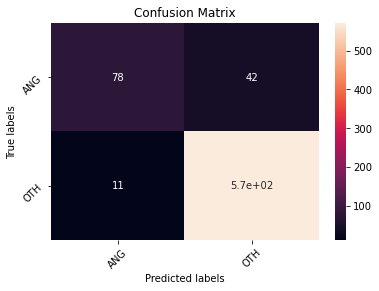

In [15]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['ANG','OTH']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);


In [16]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9246088193456614


In [17]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         ANG       0.88      0.65      0.75       120
         OTH       0.93      0.98      0.96       583

    accuracy                           0.92       703
   macro avg       0.90      0.82      0.85       703
weighted avg       0.92      0.92      0.92       703



<h2>K-Fold Training and Evaluation</h2>

In [18]:
folder = "models"
mode_version = "fem_ang_oth_v_1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/fem_ang_oth_v_1


In [19]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [22]:
#This will clone the model, but use new layers - we can reset these without affective the saved ones
model2 = tf.keras.models.clone_model(model)
model2.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=2

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    reset_weights(model2) #Reset the model before training
    history = model2.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    model2.save(model_file) #Save the model
    
    count+=1




Original trainingset shape [('OTH', 2098), ('ANG', 432)]
Resampled training set shape [('OTH', 2098), ('ANG', 2098)]
After OverSampling
X_train: shape=  (4196, 109, 167, 1)
Y_train: shape=  (4196, 2)
Epoch 1/100
525/525 - 16s - loss: 0.5036 - accuracy: 0.7726 - val_loss: 6.1142 - val_accuracy: 0.1706
Epoch 2/100
525/525 - 4s - loss: 0.3570 - accuracy: 0.8437 - val_loss: 1.5427 - val_accuracy: 0.8294
Epoch 3/100
525/525 - 3s - loss: 0.3441 - accuracy: 0.8489 - val_loss: 0.3925 - val_accuracy: 0.8578
Epoch 4/100
525/525 - 4s - loss: 0.3234 - accuracy: 0.8675 - val_loss: 1.3528 - val_accuracy: 0.8294
Epoch 5/100
525/525 - 3s - loss: 0.2975 - accuracy: 0.8801 - val_loss: 0.4352 - val_accuracy: 0.8515
Epoch 6/100
525/525 - 4s - loss: 0.2818 - accuracy: 0.8830 - val_loss: 4.8963 - val_accuracy: 0.1706
Epoch 7/100
525/525 - 3s - loss: 0.2857 - accuracy: 0.8892 - val_loss: 2.3128 - val_accuracy: 0.1912
Epoch 8/100
525/525 - 3s - loss: 0.2667 - accuracy: 0.8916 - val_loss: 1.8343 - val_accuracy

Epoch 43/100
525/525 - 4s - loss: 0.0373 - accuracy: 0.9905 - val_loss: 1.3989 - val_accuracy: 0.8499
Epoch 44/100
525/525 - 4s - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.4067 - val_accuracy: 0.8878
Epoch 45/100
Restoring model weights from the end of the best epoch.
525/525 - 4s - loss: 0.0652 - accuracy: 0.9824 - val_loss: 0.3316 - val_accuracy: 0.8878
Epoch 00045: early stopping
models/fem_ang_oth_v_1_iter_2.model
INFO:tensorflow:Assets written to: models/fem_ang_oth_v_1_iter_2.model/assets
Original trainingset shape [('OTH', 2097), ('ANG', 433)]
Resampled training set shape [('OTH', 2097), ('ANG', 2097)]
After OverSampling
X_train: shape=  (4194, 109, 167, 1)
Y_train: shape=  (4194, 2)
Epoch 1/100
525/525 - 3s - loss: 0.4907 - accuracy: 0.7759 - val_loss: 3.1411 - val_accuracy: 0.1706
Epoch 2/100
525/525 - 4s - loss: 0.3832 - accuracy: 0.8309 - val_loss: 0.7760 - val_accuracy: 0.8278
Epoch 3/100
525/525 - 4s - loss: 0.3349 - accuracy: 0.8550 - val_loss: 0.3307 - val_accuracy: 

Epoch 00038: early stopping
models/fem_ang_oth_v_1_iter_4.model
INFO:tensorflow:Assets written to: models/fem_ang_oth_v_1_iter_4.model/assets
Original trainingset shape [('OTH', 2097), ('ANG', 433)]
Resampled training set shape [('OTH', 2097), ('ANG', 2097)]
After OverSampling
X_train: shape=  (4194, 109, 167, 1)
Y_train: shape=  (4194, 2)
Epoch 1/100
525/525 - 3s - loss: 0.4725 - accuracy: 0.7864 - val_loss: 5.7083 - val_accuracy: 0.1706
Epoch 2/100
525/525 - 3s - loss: 0.3625 - accuracy: 0.8419 - val_loss: 2.4157 - val_accuracy: 0.8294
Epoch 3/100
525/525 - 4s - loss: 0.3397 - accuracy: 0.8584 - val_loss: 1.7600 - val_accuracy: 0.8294
Epoch 4/100
525/525 - 4s - loss: 0.3334 - accuracy: 0.8584 - val_loss: 0.7735 - val_accuracy: 0.5308
Epoch 5/100
525/525 - 4s - loss: 0.2906 - accuracy: 0.8770 - val_loss: 0.5225 - val_accuracy: 0.8325
Epoch 6/100
525/525 - 4s - loss: 0.3101 - accuracy: 0.8772 - val_loss: 1.6368 - val_accuracy: 0.8294
Epoch 7/100
525/525 - 4s - loss: 0.2891 - accuracy: 

Epoch 34/100
Restoring model weights from the end of the best epoch.
525/525 - 4s - loss: 0.0712 - accuracy: 0.9800 - val_loss: 1.0572 - val_accuracy: 0.8594
Epoch 00034: early stopping
models/fem_ang_oth_v_1_iter_6.model
INFO:tensorflow:Assets written to: models/fem_ang_oth_v_1_iter_6.model/assets
Original trainingset shape [('OTH', 2098), ('ANG', 433)]
Resampled training set shape [('OTH', 2098), ('ANG', 2098)]
After OverSampling
X_train: shape=  (4196, 109, 167, 1)
Y_train: shape=  (4196, 2)
Epoch 1/100
525/525 - 4s - loss: 0.4632 - accuracy: 0.7903 - val_loss: 2.5109 - val_accuracy: 0.1738
Epoch 2/100
525/525 - 3s - loss: 0.3459 - accuracy: 0.8584 - val_loss: 6.1905 - val_accuracy: 0.1706
Epoch 3/100
525/525 - 4s - loss: 0.3337 - accuracy: 0.8613 - val_loss: 4.5283 - val_accuracy: 0.8294
Epoch 4/100
525/525 - 4s - loss: 0.3167 - accuracy: 0.8663 - val_loss: 2.0113 - val_accuracy: 0.8294
Epoch 5/100
525/525 - 3s - loss: 0.2953 - accuracy: 0.8794 - val_loss: 0.9948 - val_accuracy: 0.

Original trainingset shape [('OTH', 2098), ('ANG', 433)]
Resampled training set shape [('OTH', 2098), ('ANG', 2098)]
After OverSampling
X_train: shape=  (4196, 109, 167, 1)
Y_train: shape=  (4196, 2)
Epoch 1/100
525/525 - 4s - loss: 0.4615 - accuracy: 0.7893 - val_loss: 4.0268 - val_accuracy: 0.1706
Epoch 2/100
525/525 - 4s - loss: 0.3632 - accuracy: 0.8451 - val_loss: 1.3010 - val_accuracy: 0.4550
Epoch 3/100
525/525 - 4s - loss: 0.3205 - accuracy: 0.8649 - val_loss: 1.5927 - val_accuracy: 0.8294
Epoch 4/100
525/525 - 4s - loss: 0.3103 - accuracy: 0.8684 - val_loss: 1.8584 - val_accuracy: 0.8278
Epoch 5/100
525/525 - 4s - loss: 0.2941 - accuracy: 0.8816 - val_loss: 3.2003 - val_accuracy: 0.8278
Epoch 6/100
525/525 - 4s - loss: 0.2804 - accuracy: 0.8868 - val_loss: 3.8586 - val_accuracy: 0.1801
Epoch 7/100
525/525 - 4s - loss: 0.2863 - accuracy: 0.8878 - val_loss: 0.5823 - val_accuracy: 0.8294
Epoch 8/100
525/525 - 3s - loss: 0.2816 - accuracy: 0.8897 - val_loss: 0.3458 - val_accuracy:

Epoch 36/100
525/525 - 4s - loss: 0.0446 - accuracy: 0.9843 - val_loss: 0.4331 - val_accuracy: 0.8768
Epoch 37/100
Restoring model weights from the end of the best epoch.
525/525 - 4s - loss: 0.0721 - accuracy: 0.9797 - val_loss: 1.1428 - val_accuracy: 0.5355
Epoch 00037: early stopping
models/fem_ang_oth_v_1_iter_10.model
INFO:tensorflow:Assets written to: models/fem_ang_oth_v_1_iter_10.model/assets


## Load and Evaluate

In [24]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=2

In [25]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    print('File Name Loaded: ',model_file)
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getEmotion(x))
        predict_labeled.append(getEmotion(y))
        
    labels = ['ANG','OTH']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    

File Name Loaded:  models/fem_ang_oth_v_1_iter_1.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_2.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_3.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_4.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_5.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_6.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_7.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_8.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_9.model
File Name Loaded:  models/fem_ang_oth_v_1_iter_10.model


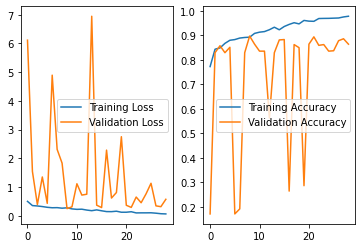

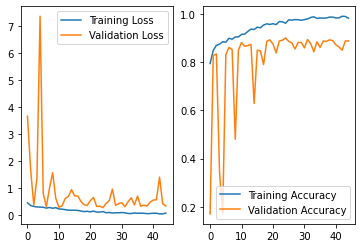

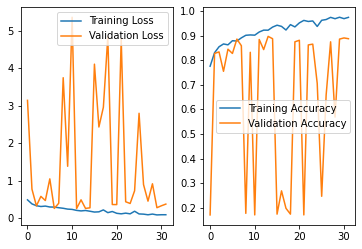

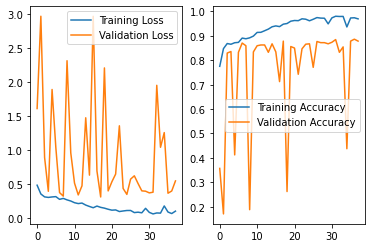

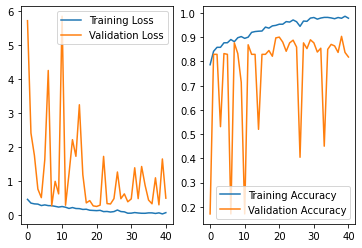

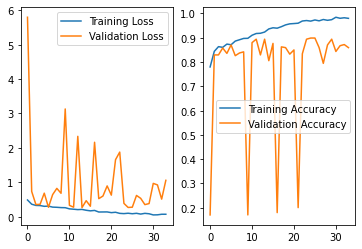

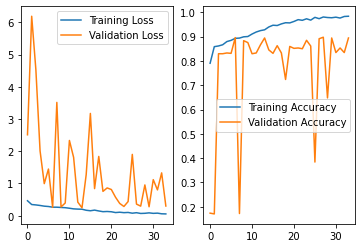

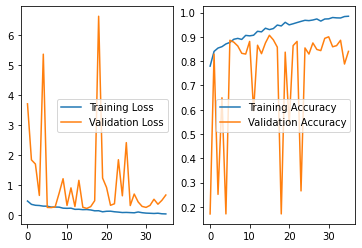

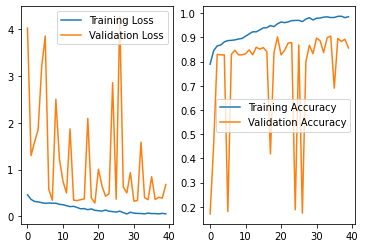

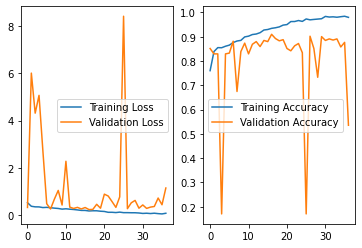

In [26]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [27]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.93218825 0.72831333]
precision sdev by class [0.02012231 0.089074  ]
macro precision mean 0.8302507856298119
macro precision sdev 0.040028776120707814
recall mean [0.94405451 0.66248634]
recall sdev [0.02926581 0.11189984]
macro recall mean 0.80327042543619
macro recall sdev 0.04504765105941794
f1 mean [0.93750722 0.68233911]
f1 sdev [0.00945967 0.04718054]
macro f1 mean 0.8099231673731438
macro f1 sdev 0.026321958185648642
accuracy mean 0.8958754208754207
accuracy sdev 0.014575569290576077


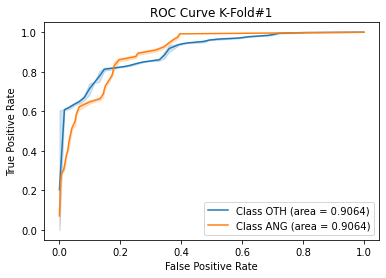

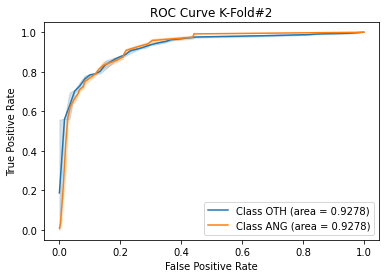

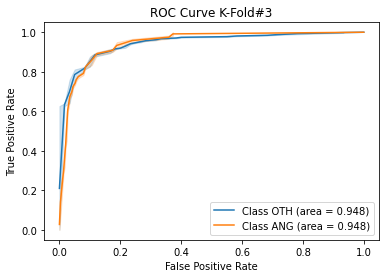

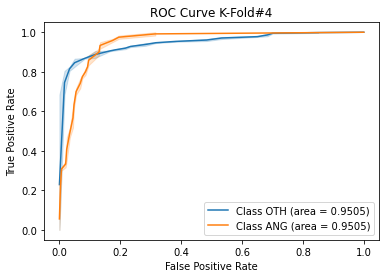

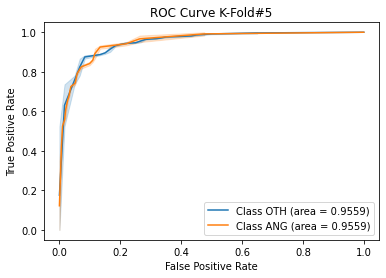

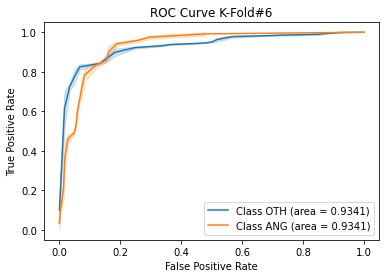

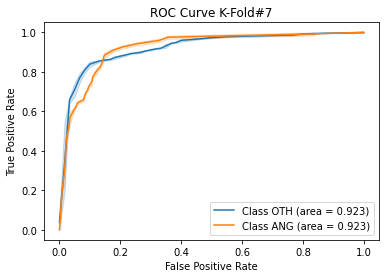

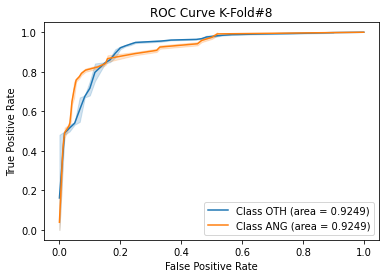

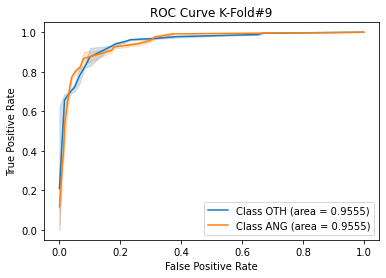

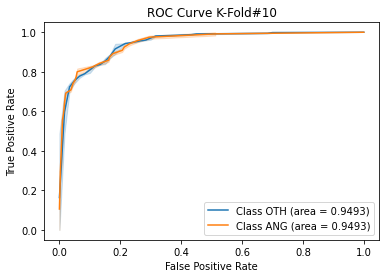

In [28]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [29]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getEmotion(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  OTH
AUC Mean  0.9375446620924823
Std  0.015869668590926287
Sp:  ANG
AUC Mean  0.9375446620924823
Std  0.0158696685909263


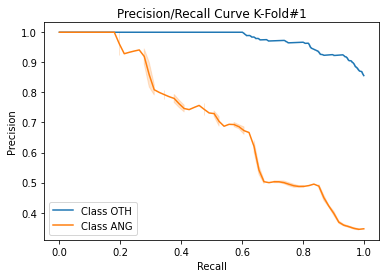

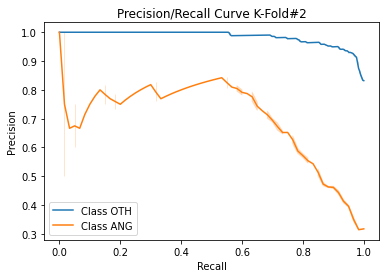

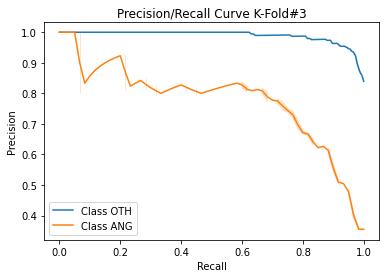

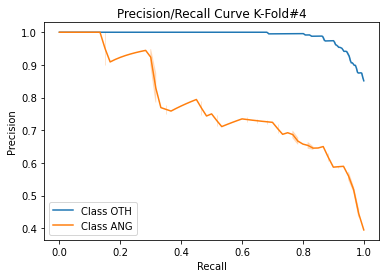

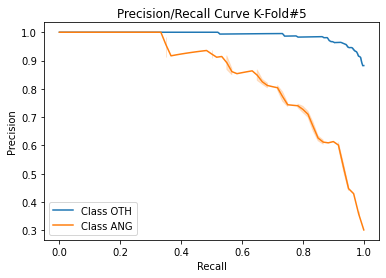

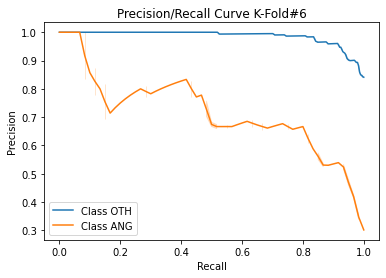

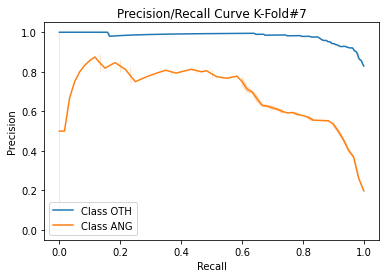

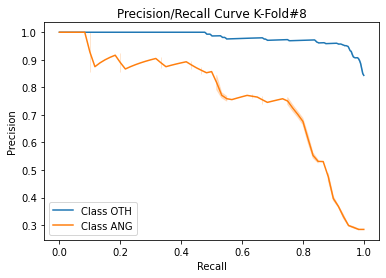

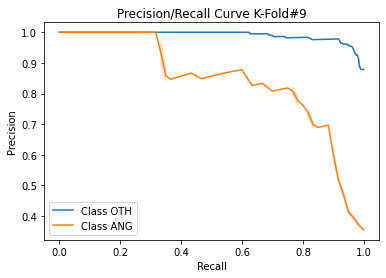

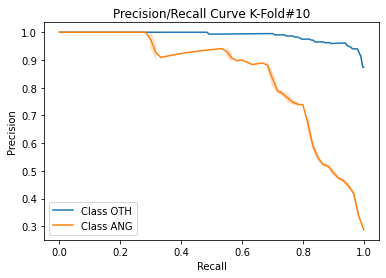

In [30]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

Confusion Matrix K-Fold #1

[[ 31  30]
 [ 12 279]]


Confusion Matrix K-Fold #2

[[ 41  19]
 [ 16 276]]


Confusion Matrix K-Fold #3

[[ 50  10]
 [ 25 267]]


Confusion Matrix K-Fold #4

[[ 32  28]
 [ 13 279]]


Confusion Matrix K-Fold #5

[[ 33  27]
 [  4 288]]


Confusion Matrix K-Fold #6

[[ 39  21]
 [ 19 272]]


Confusion Matrix K-Fold #7

[[ 47  13]
 [ 33 258]]


Confusion Matrix K-Fold #8

[[ 40  20]
 [ 13 278]]


Confusion Matrix K-Fold #9

[[ 36  24]
 [  5 286]]


Confusion Matrix K-Fold #10

[[ 49  11]
 [ 23 268]]




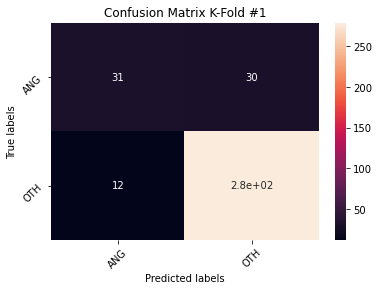

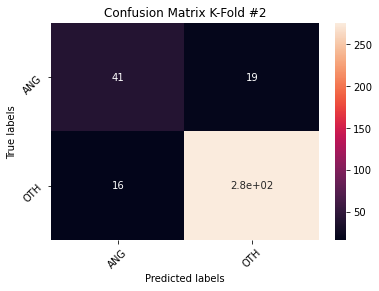

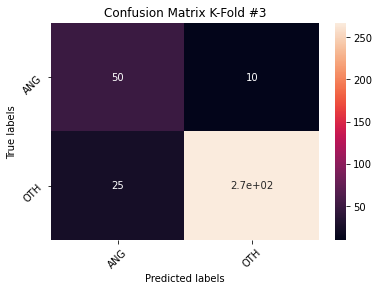

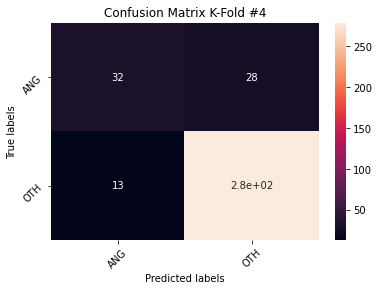

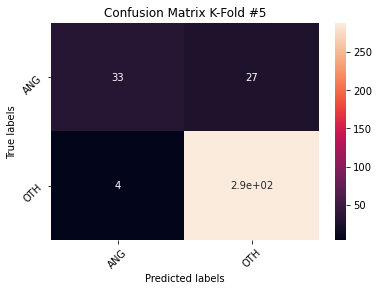

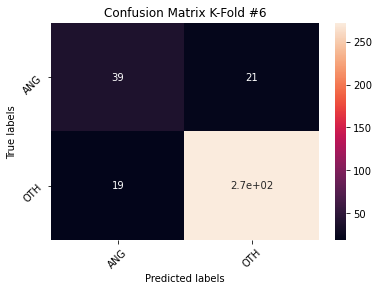

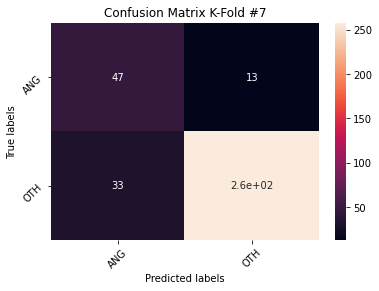

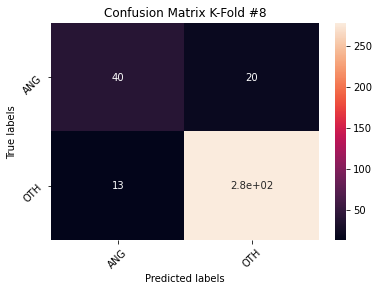

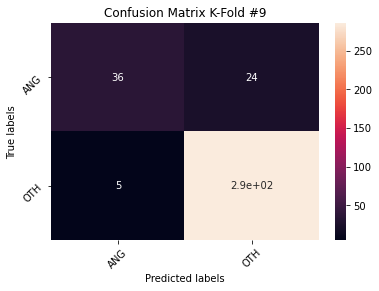

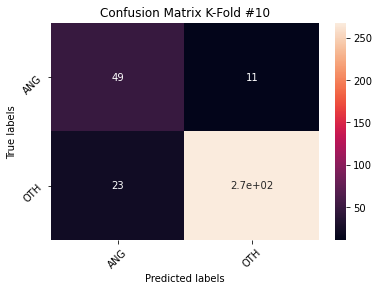

In [31]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[ 398  203]
 [ 163 2751]]

average of all confuion matrices
 [[ 39  20]
 [ 16 275]]


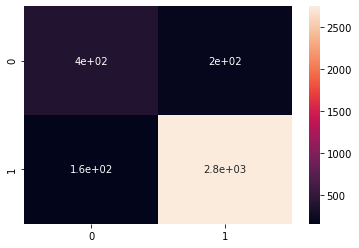

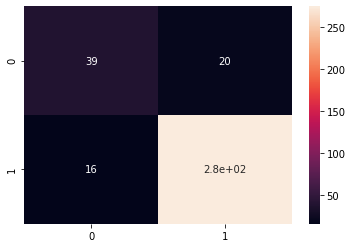

In [32]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.66 0.34]
 [0.06 0.94]]


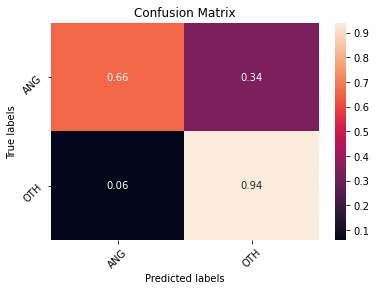

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['ANG','OTH']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);